In [3]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16 # load VGG16 model from keras
from keras.preprocessing.image import load_img # Using images library
from keras.preprocessing.image import img_to_array # # convert image pixels to numpy for specific manipulations
from keras.applications.vgg16 import preprocess_input # to prepare for new input
from keras.applications.vgg16 import decode_predictions # for reporting probabilities

#For Keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\xris1\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\Users\xris1\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\Users\xris1\anaconda3\lib\site-packages\tensorflow_core\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\Users\xris1\anaconda3\lib\imp.py", line 242, in load_module
    else:
  File "C:\Users\xris1\anaconda3\lib\imp.py", line 342, in load_dynamic
    name=name, loader=loader, origin=path)
ImportError: Module use of python36.dll conflicts with this version of Python.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):


TypeError: can only concatenate str (not "list") to str

In [2]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# prepare an iterators for each dataset
train_it = train_datagen.flow_from_directory('data/images/train',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

validate_it = train_datagen.flow_from_directory('data/images/validate',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True)

train_batchX, train_batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (train_batchX.shape, train_batchX.min(), train_batchX.max()))
validate_batchX, validate_batchy = validate_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (validate_batchX.shape, validate_batchX.min(), validate_batchX.max()))

Found 225 images belonging to 5 classes.
Found 48 images belonging to 5 classes.
Batch shape=(32, 224, 224, 3), min=-123.680, max=151.061
Batch shape=(32, 224, 224, 3), min=-123.680, max=151.061


In [3]:
# classifying only weapons 
vgg16_model = VGG16(weights="imagenet")

In [ ]:
# DO NOT RUN IF YOU ARE DOING CPU
#pysical_devices = tf.config.list_physical_devices('GPU') 

#try: 
    #  tf.config.experimental.set_memory_growth(physical_devices[0], True)
#except: 
    # Invalid device or cannot modify virtual devices once initialized. 
    #  pass 

In [ ]:
# Check devices on computer!
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [4]:
seq_model = Sequential()

# iterate all layers in vgg16 to sequential for custom modification
for layer in vgg16_model.layers:
    seq_model.add(layer)
    
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [5]:
# 1000 categories, pop off output layer to work only specific categories
seq_model._layers.pop()

In [6]:
# freeze weights to prevent constantly updating weights
for layer in seq_model._layers:
    layer.trainable = False
    # SET TO FALSE IF YOU DO NOT WANNA TRAIN THE MODEL!

In [7]:
seq_model.add(Dense(200, activation='relu')) # 5 categories 

seq_model.add(Dense(55, activation='relu'))
seq_model.add(Dense(5, activation='softmax'))

seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [8]:
seq_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = train_it.n//train_it.batch_size #np.ceil((train_it.n//train_it.batch_size)/2)
history = seq_model.fit_generator(generator=train_it,
                                  validation_data=validate_it,
                                  validation_freq=1,
                                  steps_per_epoch=step_size_train,
                                  shuffle=True,
                                  epochs=25)


Epoch 1/25
7/7 [==============================] - 59s 8s/step - loss: 1.5716 - accuracy: 0.4974 - val_loss: 1.5881 - val_accuracy: 0.2292
Epoch 2/25
7/7 [==============================] - 58s 8s/step - loss: 1.5130 - accuracy: 0.4508 - val_loss: 1.5560 - val_accuracy: 0.2292
Epoch 3/25
7/7 [==============================] - 58s 8s/step - loss: 1.3902 - accuracy: 0.5596 - val_loss: 1.5634 - val_accuracy: 0.2500
Epoch 4/25
7/7 [==============================] - 66s 9s/step - loss: 1.2613 - accuracy: 0.7455 - val_loss: 1.6365 - val_accuracy: 0.3125
Epoch 5/25
7/7 [==============================] - 50s 7s/step - loss: 1.1488 - accuracy: 0.7593 - val_loss: 1.7115 - val_accuracy: 0.2708
Epoch 6/25
7/7 [==============================] - 61s 9s/step - loss: 0.9456 - accuracy: 0.8482 - val_loss: 1.4841 - val_accuracy: 0.3542
Epoch 7/25
7/7 [==============================] - 57s 8s/step - loss: 0.8452 - accuracy: 0.9067 - val_loss: 1.7901 - val_accuracy: 0.3750
Epoch 8/25
7/7 [=================

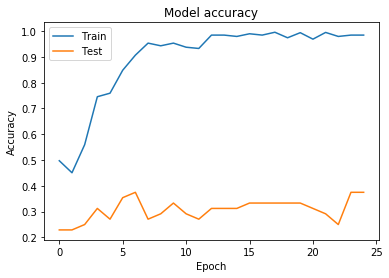

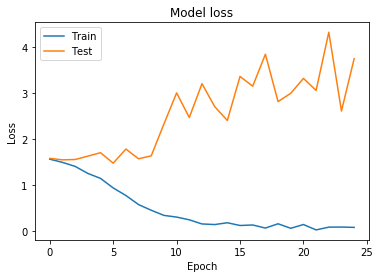

In [9]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# TO PREDICT PROPERLY YOU NEED TO FEED IT AN IMAGE THAT IS NOT IN THE VALIDATION OR TEST!
prediction = seq_model.predict(validate_batchX)

# convert the probabilities to class labels
#label = decode_predictions(pred)

for row in range(len(prediction)):
    biggest = np.argmax(prediction[row])
    for val in range(len(prediction[row])):
        if(val == biggest):
            prediction[row][val] = 1.
        else:
            prediction[row][val] = 0.

# retrieve the most likely result, e.g. highest probability
test_prediction = prediction == validate_batchy

In [ ]:
# HOW MANY OF THE TESTS WERE WRONG
print((np.sum(test_prediction % 2 == 0))/2)

In [67]:
# test image 
test_it = ImageDataGenerator(preprocessing_function=preprocess_input)
test_it = test_it.flow_from_directory('data/images/test/',
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     batch_size=32,
                                     class_mode='categorical',
                                     shuffle=True,
                                     classes=['assault_rifles','grenade_launchers','pistols','shotguns','sniper_rifles']
                                     )

test_batchX, test_batchy = test_it.next()

print("labels: ", test_it.class_indices)

print('Batch shape=%s, min=%.3f, max=%.3f' % (test_batchX.shape, test_batchX.min(), test_batchX.max()))

Found 2 images belonging to 5 classes.
labels:  {'assault_rifles': 0, 'grenade_launchers': 1, 'pistols': 2, 'shotguns': 3, 'sniper_rifles': 4}
Batch shape=(2, 224, 224, 3), min=-123.680, max=151.061


In [63]:
result = seq_model.predict(test_it)

for row in range(len(result)):
    biggest = np.argmax(result[row])
    for val in range(len(result[row])):
        if(val == biggest):
            result[row][val] = 1.
        else:
            result[row][val] = 0.

result

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

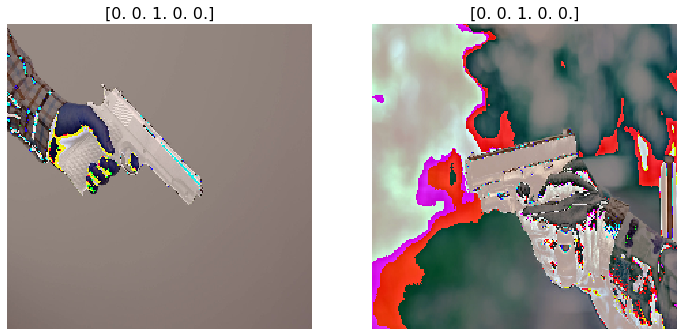

In [64]:
# plot function, used to plot images with labels 
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# we plot these samples of images and their labels 1 batch at a time.
plots(test_batchX, titles=test_batchy)